In [1]:
!pip install tensorflow==2.0

     |████████████████████████████████| 86.3MB 52kB/s 
     |████████████████████████████████| 3.8MB 55.4MB/s 
     |████████████████████████████████| 450kB 63.6MB/s 
     |████████████████████████████████| 81kB 13.2MB/s 
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.10.1 which is incompatible.
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstall

Reproduced with code from this excellent [blog](https://towardsdatascience.com/faster-r-cnn-object-detection-implemented-by-keras-for-custom-data-from-googles-open-images-125f62b9141a)

In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from skimage import io
from shutil import copyfile
import sys
import time

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
tf.__version__

'2.0.0'

### Load data from .csv file

* `train-images-boxable.csv` file contains the image name and image url
* `train-annotations-bbox.csv` file contains the bounding box info with the image id (name) and the image label name
* `class-descriptions-boxable.csv` file contains the image label name corresponding to its class name

Download link:

https://storage.googleapis.com/openimages/web/download.html

https://www.figure-eight.com/dataset/open-images-annotated-with-bounding-boxes/

In [11]:
!python -m wget https://storage.googleapis.com/openimages/2018_04/train/train-annotations-bbox.csv


Saved under train-annotations-bbox.csv


In [12]:
!python -m wget https://storage.googleapis.com/openimages/2018_04/train/train-images-boxable-with-rotation.csv


Saved under train-images-boxable-with-rotation.csv


The original code used "***train-images-boxable.csv***" but I couldn't find it. So, I am using "***train-images-boxable-with-rotations.csv"***

In [13]:
!python -m wget https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv


Saved under class-descriptions-boxable.csv


In [3]:
images_boxable_fname = 'train-images-boxable-with-rotation.csv'
annotations_bbox_fname = 'train-annotations-bbox.csv'
class_descriptions_fname = 'class-descriptions-boxable.csv'

In [4]:
images_boxable = pd.read_csv(images_boxable_fname)
images_boxable.head()

,ImageID,Subset,OriginalURL,OriginalLandingURL,License,AuthorProfileURL,Author,Title,OriginalSize,OriginalMD5,Thumbnail300KURL,Rotation
0,4fa8054781a4c382,train,https://farm3.staticflickr.com/5310/5898076654...,https://www.flickr.com/photos/michael-beat/589...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/michael-beat/,Michael Beat,...die FNF-Kerze,4405052,KFukvivpCM5QXl5SqKe41g==,https://c1.staticflickr.com/6/5310/5898076654_...,0.0
1,b37f763ae67d0888,train,https://c1.staticflickr.com/1/67/197493648_628...,https://www.flickr.com/photos/drstarbuck/19749...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/drstarbuck/,Karen,Three boys on a hill,494555,9IzEn38GRNsVpATuv7gzEA==,https://c3.staticflickr.com/1/67/197493648_628...,0.0
2,7e8584b0f487cb9e,train,https://c7.staticflickr.com/8/7056/7143870979_...,https://www.flickr.com/photos/circasassy/71438...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/circasassy/,CircaSassy,A Christmas carol and The cricket on the heart...,2371584,3hQwu0iSzY1VIoXiwp0/Mg==,https://c7.staticflickr.com/8/7056/7143870979_...,0.0
3,86638230febe21c4,train,https://farm5.staticflickr.com/5128/5301868579...,https://www.flickr.com/photos/ajcreencia/53018...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/ajcreencia/,Alex,Abbey and Kenny,949267,onB+rCZnGQg5PRX7xOs18Q==,https://c4.staticflickr.com/6/5128/5301868579_...,NaN
4,249086e72671397d,train,https://c6.staticflickr.com/4/3930/15342460029...,https://www.flickr.com/photos/codnewsroom/1534...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/codnewsroom/,COD Newsroom,Suburban Law Enforcement Academy 20th Annivers...,6541758,MjpaAVbMAWbCusSaxI1D7w==,https://c1.staticflickr.com/4/3930/15342460029...,0.0


In [5]:
annotations_bbox = pd.read_csv(annotations_bbox_fname)
annotations_bbox.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
0,000002b66c9c498e,xclick,/m/01g317,1,0.012500,0.195312,0.148438,0.587500,0,1,0,0,0
1,000002b66c9c498e,xclick,/m/01g317,1,0.025000,0.276563,0.714063,0.948438,0,1,0,0,0
2,000002b66c9c498e,xclick,/m/01g317,1,0.151562,0.310937,0.198437,0.590625,1,0,0,0,0
3,000002b66c9c498e,xclick,/m/01g317,1,0.256250,0.429688,0.651563,0.925000,1,0,0,0,0
4,000002b66c9c498e,xclick,/m/01g317,1,0.257812,0.346875,0.235938,0.385938,1,0,0,0,0


1. **XMin, XMax, YMin, YMax**: coordinates of the box, in normalized image coordinates.
2. **IsOccluded**: Indicates that the object is occluded by another object in the image.
3. **IsTruncated**: Indicates that the object extends beyond the boundary of the image.
4. **IsGroupOf**: Indicates that the box spans a group of objects (e.g., a bed of flowers or a crowd of people). We asked annotators to use this tag for cases with more than 5 instances which are heavily occluding each other and are physically touching.
5. **IsDepiction**: Indicates that the object is a depiction (e.g., a cartoon or drawing of the object, not a real physical instance).
6. **IsInside**: Indicates a picture taken from the inside of the object (e.g., a car interior or inside of a building).


In [6]:
class_descriptions = pd.read_csv(class_descriptions_fname, header=None)
class_descriptions.head()

,0,1
0,/m/011k07,Tortoise
1,/m/011q46kg,Container
2,/m/012074,Magpie
3,/m/0120dh,Sea turtle
4,/m/01226z,Football


### Plot Bounding box

In [7]:
def plot_bbox(img_id):
  img_url = images_boxable.loc[images_boxable["ImageID"]==img_id]['OriginalURL'].values[0]
  img = io.imread(img_url)
  height, width, channel = img.shape
  print(f"Image: {img.shape}")
  bboxs = annotations_bbox[annotations_bbox['ImageID']==img_id]
  for index, row in bboxs.iterrows():
      xmin = row['XMin']
      xmax = row['XMax']
      ymin = row['YMin']
      ymax = row['YMax']
      xmin = int(xmin*width)
      xmax = int(xmax*width)
      ymin = int(ymin*height)
      ymax = int(ymax*height)
      label_name = row['LabelName']
      class_series = class_descriptions[class_descriptions[0]==label_name]
      class_name = class_series[1].values[0]
      print(f"Coordinates: {xmin,ymin}, {xmax,ymax}")
      cv2.rectangle(img, (xmin,ymin), (xmax,ymax), (255,0,0), 5)
      font = cv2.FONT_HERSHEY_SIMPLEX
      cv2.putText(img, class_name, (xmin,ymin-10), font, 3, (0,255,0), 5)
  plt.figure(figsize=(15,10))
  plt.title('Image with Bounding Box')
  plt.imshow(img)
  plt.axis("off")
  plt.show()

Finding images with lesser number of objects so as easy to visualize

In [8]:
least_objects_img_ids = annotations_bbox["ImageID"].value_counts().tail(50).index.values

Image: (3529, 5316, 3)
Coordinates: (1428, 1196), (1591, 1292)


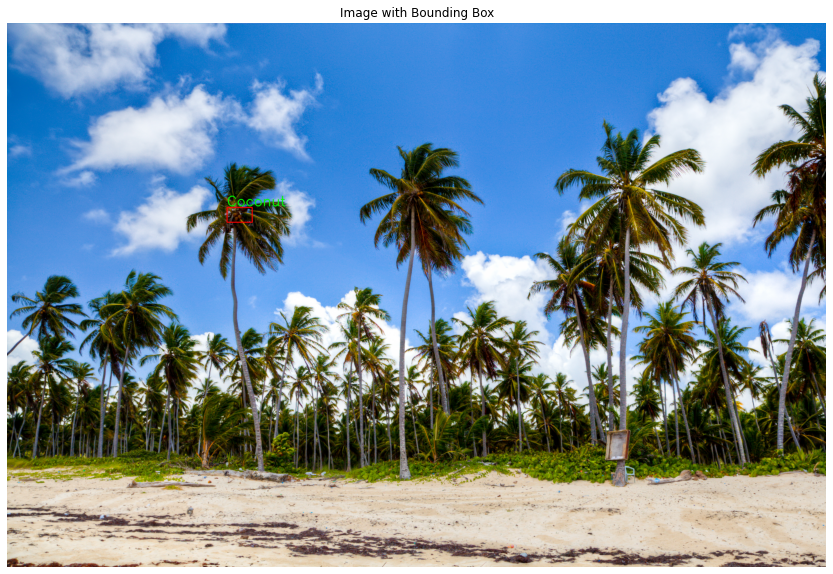

HTTPError: HTTP Error 404: Not Found

In [9]:
for img_id in random.sample(list(least_objects_img_ids), 5):
  plot_bbox(img_id)

### Get subset of the whole dataset

For here, I just want to detect three classes, which include person, mobile phone and car. We just extract 1000 images for each class from the whole dataset.

In [10]:
class_descriptions.loc[class_descriptions[1].isin(['Car', 'Vehicle registration plate'])]

,0,1
82,/m/01jfm_,Vehicle registration plate
570,/m/0k4j,Car


In [11]:
# Find the label_name for 'Person', 'Mobile Phone' and 'Car' classes
car_pd = class_descriptions[class_descriptions[1]=='Car']
rplate_pd = class_descriptions[class_descriptions[1]=='Vehicle registration plate']


label_name_car = car_pd[0].values[0]
label_name_rplate = rplate_pd[0].values[0]


**Be careful that there might be several object in one image. For example, there are three person and two mobile phone in one image**

In [12]:
car_bbox = annotations_bbox[annotations_bbox['LabelName']==label_name_car]
rplate_bbox = annotations_bbox[annotations_bbox['LabelName']==label_name_rplate]

In [13]:
print('There are %d cars in the dataset' %(len(car_bbox)))
print('There are %d rplate in the dataset' %(len(rplate_bbox)))
car_img_id = car_bbox['ImageID']
rplate_img_id = rplate_bbox['ImageID']

There are 248075 cars in the dataset
There are 7852 rplate in the dataset


In [14]:
car_img_id = np.unique(car_img_id)
rplate_img_id = np.unique(rplate_img_id)

print('There are %d images which contain cars' % (len(car_img_id)))
print('There are %d images which contain car platess' % (len(rplate_img_id)))

There are 89465 images which contain cars
There are 5368 images which contain car platess


We just randomly pick 1000 images in here.

In [15]:
# here I've chosen only 10 images for speed, change it to your liking
n = 10
subcar_img_id = random.sample(list(car_img_id), n)
subrplate_img_id = random.sample(list(rplate_img_id),n)

In [16]:

subcar_pd = images_boxable.loc[images_boxable['ImageID'].isin(subcar_img_id)]
subrplate_pd = images_boxable.loc[images_boxable['ImageID'].isin(subrplate_img_id)]

In [17]:
subcar_pd.shape

(10, 12)

In [18]:
subcar_pd.head()

,ImageID,Subset,OriginalURL,OriginalLandingURL,License,AuthorProfileURL,Author,Title,OriginalSize,OriginalMD5,Thumbnail300KURL,Rotation
89797,ba2c93e0add43a5e,train,https://c7.staticflickr.com/4/3687/9639300859_...,https://www.flickr.com/photos/vernieman/963930...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/vernieman/,Vernon Chan,Editing on the fly. Check out pics later on fl...,117582,tqhwCzRvPbYJMTfkUkCbpQ==,https://c1.staticflickr.com/4/3687/9639300859_...,NaN
138545,6970cb217be1dc99,train,https://c2.staticflickr.com/8/7055/6829923510_...,https://www.flickr.com/photos/thedigitelmyr/68...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/thedigitelmyr/,Myrtle Beach TheDigitel,2011_St Patricks Day Parade_North Myrtle Beach-38,3544170,2mAYurMFVlGNl/7kkJsv7A==,https://c7.staticflickr.com/8/7055/6829923510_...,0.0
218849,6f6469b661188809,train,https://c2.staticflickr.com/6/5072/14260842431...,https://www.flickr.com/photos/30474136@N07/142...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/30474136@N07/,TuRbO_J,SA Ambulance Service - Mitsubishi Challenger,2757804,NgUIHbXQ1pI81eC9k9NYkw==,https://c5.staticflickr.com/6/5072/14260842431...,0.0
471164,509415c986ab2cc4,train,https://farm5.staticflickr.com/42/84619179_08a...,https://www.flickr.com/photos/daquellamanera/8...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/daquellamanera/,Daniel Lobo,Calle Mayor,1149694,TAY4J1ld9ggFupo9ynMQvQ==,https://c4.staticflickr.com/1/42/84619179_08a7...,0.0
620041,70dd2f625427734c,train,https://c5.staticflickr.com/3/2168/5776022338_...,https://www.flickr.com/photos/kaja_a/5776022338,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/kaja_a/,Kaja Avberšek,stoenka,603298,rot/laIZldVCBQUvj6PlMQ==,https://c8.staticflickr.com/3/2168/5776022338_...,0.0


In [19]:
subcar_dict = subcar_pd[["ImageID", "OriginalURL"]].set_index('ImageID')["OriginalURL"].to_dict()
subrplate_dict = subrplate_pd[["ImageID", "OriginalURL"]].set_index('ImageID')["OriginalURL"].to_dict()

In [20]:
# subperson_img_url = subperson_pd['OriginalURL'].tolist()
# subphone_img_url = subphone_pd['OriginalURL'].tolist()
# subcar_img_url = subcar_pd['OriginalURL'].tolist()

In [21]:
mappings = [subcar_dict, subrplate_dict]

In [22]:
len(mappings)

2

In [23]:
len(mappings[0])

10

In [24]:
classes = ['Car','Vehicle registration plate']

### Download images

We need to save the images with filename as `image id` with jpg extension

In [25]:
# download images
for idx, obj_type in enumerate(classes):
  n_issues = 0
  # create the directory
  if not os.path.exists(obj_type):
    os.mkdir(obj_type)
  for img_id, url in mappings[idx].items():
    try:
      img = io.imread(url)
      saved_path = os.path.join(obj_type, img_id+".jpg")
      io.imsave(saved_path, img)
    except Exception as e:
      n_issues += 1
  print(f"Images Issues: {n_issues}")

Images Issues: 1
Images Issues: 1


In [38]:
!python -m ls Person | wc -l

'wc'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


In [83]:
!ls Mobile\ phone | wc -l

7


In [84]:
!ls Car | wc -l

9


### Dataset format for Faster-RCNN code

(fname_path, xmin, xmax, ymin, ymax, class_name)

train: 0.8
validation: 0.2

In [28]:
# save images to train and test directory
train_path = 'train'
test_path = 'test'

In [29]:
!mkdir train test

In [30]:
random.seed(1)

In [31]:
for i in range(len(classes)):
    all_imgs = os.listdir(classes[i])
    all_imgs = [f for f in all_imgs if not f.startswith('.')]
    random.shuffle(all_imgs)
    
    limit = int(n*0.8)

    train_imgs = all_imgs[:limit]
    test_imgs = all_imgs[limit:]
    
    # copy each classes' images to train directory
    for j in range(len(train_imgs)):
        original_path = os.path.join(classes[i], train_imgs[j])
        new_path = os.path.join(train_path, train_imgs[j])
        copyfile(original_path, new_path)
    
    # copy each classes' images to test directory
    for j in range(len(test_imgs)):
        original_path = os.path.join(classes[i], test_imgs[j])
        new_path = os.path.join(test_path, test_imgs[j])
        copyfile(original_path, new_path)

In [94]:
!ls train | wc -l

23


In [95]:
!ls test | wc -l

3


The expected number of training images and validation images should be 24 and 6 respectively.

However, there might be some overlap images which appear in two or three classes simultaneously. For instance, an image might be a person walking on the street and there are several cars in the street

In [33]:
label_names = [label_name_car, label_name_rplate]

train_df = pd.DataFrame(columns=['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName'])

# Find boxes in each image and put them in a dataframe
train_imgs = os.listdir(train_path)
train_imgs = [name for name in train_imgs if not name.startswith('.')]

for i in range(len(train_imgs)):
    sys.stdout.write('Parse train_imgs ' + str(i) + '; Number of boxes: ' + str(len(train_df)) + '\r')
    sys.stdout.flush()
    img_name = train_imgs[i]
    img_id = img_name[0:16]
    tmp_df = annotations_bbox[annotations_bbox['ImageID']==img_id]
    for index, row in tmp_df.iterrows():
        labelName = row['LabelName']
        for i in range(len(label_names)):
            if labelName == label_names[i]:
                train_df = train_df.append({'FileName': img_name, 
                                            'XMin': row['XMin'], 
                                            'XMax': row['XMax'], 
                                            'YMin': row['YMin'], 
                                            'YMax': row['YMax'], 
                                            'ClassName': classes[i]}, 
                                           ignore_index=True)

In [34]:
train_df.head()

,FileName,XMin,XMax,YMin,YMax,ClassName
0,0e19a691b96d8124.jpg,0.491875,0.753750,0.631332,0.949343,Car
1,0e19a691b96d8124.jpg,0.384375,0.512500,0.670732,0.826454,Car
2,23dede11cda1cd96.jpg,0.405625,0.531250,0.353750,0.420000,Vehicle registration plate
3,23dede11cda1cd96.jpg,0.016875,0.136875,0.088125,0.348125,Car
4,23dede11cda1cd96.jpg,0.016875,0.982500,0.508750,0.975000,Car


In [35]:
train_df.shape

(50, 6)

Let's test if they work fine by plotting the bounding box for the above 5 images

In [36]:
train_img_ids = train_df["FileName"].head().str.split(".").str[0].unique()

Image: (1365, 2048, 3)
Coordinates: (1007, 861), (1543, 1295)
Coordinates: (544, 897), (683, 1152)
Coordinates: (656, 902), (766, 1134)
Coordinates: (787, 915), (1049, 1128)


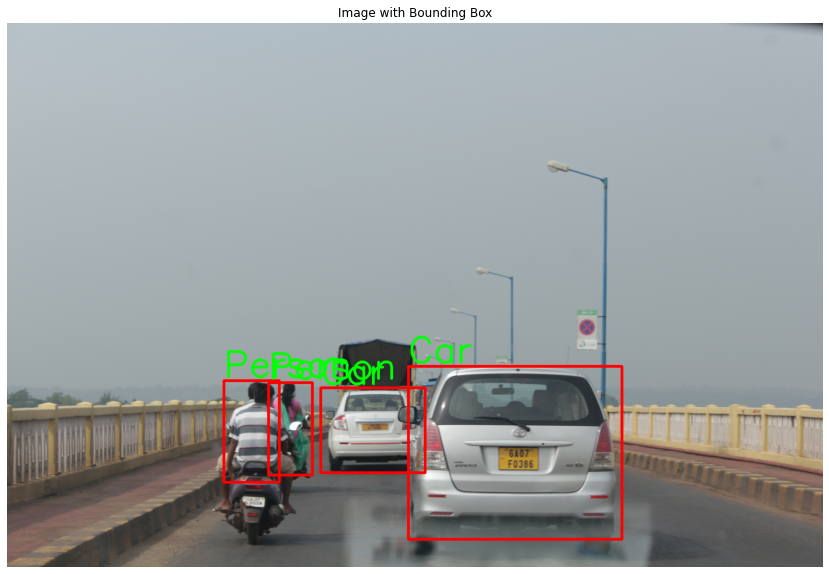

Image: (1936, 1936, 3)
Coordinates: (785, 684), (1028, 813)
Coordinates: (32, 170), (264, 673)
Coordinates: (32, 984), (1902, 1887)
Coordinates: (231, 55), (1491, 937)


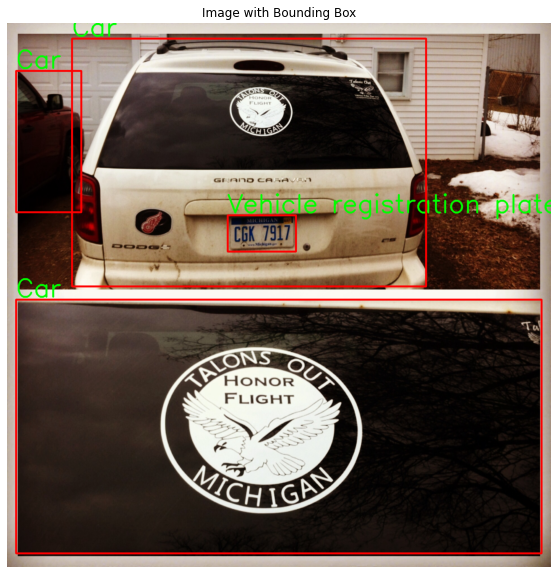

In [37]:
for img_id in train_img_ids:
  plot_bbox(img_id)

**This looks fine to me!!**

In [48]:
val_df = pd.DataFrame(columns=['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName'])

# find boxes in each image and put them in a dataframe
test_imgs = os.listdir(test_path)
test_imgs = [name for name in test_imgs if not name.startswith('.')]

for i in range(len(test_imgs)):
    sys.stdout.write('Parse test_imgs ' + str(i) + '; Number of boxes: ' + str(len(test_df)) + '\r')
    sys.stdout.flush()
    img_name = test_imgs[i]
    img_id = img_name[0:16]
    tmp_df = annotations_bbox[annotations_bbox['ImageID']==img_id]
    for index, row in tmp_df.iterrows():
        labelName = row['LabelName']
        for i in range(len(label_names)):
            if labelName == label_names[i]:
                val_df = val_df.append({'FileName': img_name, 
                                            'XMin': row['XMin'], 
                                            'XMax': row['XMax'], 
                                            'YMin': row['YMin'], 
                                            'YMax': row['YMax'], 
                                            'ClassName': classes[i]}, 
                                           ignore_index=True)

NameError: name 'test_df' is not defined

In [0]:
train_df.to_csv('train.csv')
test_df.to_csv('test.csv')

### Write train.csv to annotation.txt

In [0]:
train_df = pd.read_csv('train.csv')

# for training
with open("annotation.txt", "w+") as f:
  for idx, row in train_df.iterrows():
      img = cv2.imread('train/' + row['FileName'])
      height, width = img.shape[:2]
      x1 = int(row['XMin'] * width)
      x2 = int(row['XMax'] * width)
      y1 = int(row['YMin'] * height)
      y2 = int(row['YMax'] * height)
      
      google_colab_file_path = 'drive/My Drive/AI/Dataset/Open Images Dataset v4 (Bounding Boxes)/train'
      fileName = os.path.join(google_colab_file_path, row['FileName'])
      className = row['ClassName']
      f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + className + '\n')

In [49]:
test_df = pd.read_csv('test.csv')

# for test
with open("test_annotation.txt", "w+") as f:
  for idx, row in test_df.iterrows():
      sys.stdout.write(str(idx) + '\r')
      sys.stdout.flush()
      img = cv2.imread('test/' + row['FileName'])
      height, width = img.shape[:2]
      x1 = int(row['XMin'] * width)
      x2 = int(row['XMax'] * width)
      y1 = int(row['YMin'] * height)
      y2 = int(row['YMax'] * height)
      
      google_colab_file_path = 'drive/My Drive/AI/Dataset/Open Images Dataset v4 (Bounding Boxes)/test'
      fileName = os.path.join(google_colab_file_path, row['FileName'])
      className = row['ClassName']
      f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + className + '\n')

FileNotFoundError: [Errno 2] No such file or directory: 'test.csv'